<img src="img/saclay_center.png" width="800" height="600">

### Datacamp Challenge : Prediction of daily transport validation in Paris public underground transports 

<i> Authors :Dina ABED , Siwar ABBES, Philippe DE SAINT CHAMAS, Mohamed Skander HELLAL, Gwendal HENGOAT, Jules ZACCARDI </i>

## Data Collection

### Introduction

The Basic data used are in our challenge are the open data available on the Ile-de-France Mobilités platform which provides validation data of the entire Ile-de-France network. The transport network seen by the validation data covers 725 train stops (RER, metro, Transilien). 
Source: https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations/information/

We have merged all the data available since the first semester of 2015 until 2019. To get a whole observations of the number of validations per day and per stop. 

Thinking about some informations that could impact the frequentation of stations, our brainstorming leads to try to find other databases that contain these significant features to our business model:

- find to which metro/RER line corresponds each stop, Database exploited: https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf-data-generalisee/information/
- Search for a database of public holidays (whether public holiday or not and if so, the type of this day: Weekend, Christmas, Toussaint,...), Database exploited: https://www.data.gouv.fr/fr/datasets/jours-feries-en-france/
- Incident rate, incident data on all RATP lines per day, Database exploited: http://data.cquest.org/openeventdatabase/
- Social movements, Data on SNCF social movements: https://ressources.data.sncf.com/explore/dataset/mouvements-sociaux-depuis-2002/table/?sort=date_de_debut
- Referential of passenger stations, Database: https://data.sncf.com/explore/dataset/frequentation-gares/table/?sort=nom_gare
- Day off Database indicating if the day is a day off or not and the type of the day off (Christmas, Toussaint,...):
https://www.data.gouv.fr/fr/datasets/jours-feries-en-france/

In order to get the data for the challenge, we worked on engineering features from the different databases defined above and merging them into a challenge data csv file


### Importing the Libraries

In [49]:
import sys
import numpy as np
import pandas as pd 
from datetime import timedelta, date
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
sns.set(rc={'figure.figsize':(13.7,9.27)})
import warnings
warnings.filterwarnings('ignore')
import os
import folium
import pandas as pd
from IPython.display import display
from folium import Popup
import calendar
from sklearn.model_selection import train_test_split

### 1 . Validation Data

In [50]:
allfiles = os.listdir('./data/data valid/')
li = []

for file in allfiles : 
    print(file)
    file = './data/data valid/' + file 
    if file[-3:] == 'csv':
        data = pd.read_csv(file, header=0, sep=';')
        data['JOUR'] = pd.to_datetime(data['JOUR'])
        li.append(data)
    else:
        data = pd.read_csv(file, header=0, sep='\t')
        data['JOUR'] = pd.to_datetime(data['JOUR'])
        li.append(data)

dt = pd.concat(li, axis=0, ignore_index=True)
dt.columns = ['date', 'code_STIF_TRNS','code_STIF_RES','code_STIF_ARRET','station','id_REFA_LDA','category','nb_valid']

2015S2_NB_FER.csv
2018S1_NB_FER.txt
2017S2_NB_FER.txt
2016S2_NB_FER.txt
validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-semestre-2019.csv
2016S1_NB_FER.txt
2017S1_NB_FER.txt
2015S1_NB_FER.csv


#### Modifying the types

In [51]:
dt.head()

,date,code_STIF_TRNS,code_STIF_RES,code_STIF_ARRET,station,id_REFA_LDA,category,nb_valid
0,2015-01-07,100,110,1,PORTE MAILLOT,71379,AMETHYSTE,241
1,2015-01-07,100,110,1,PORTE MAILLOT,71379,AUTRE TITRE,215
2,2015-01-07,100,110,1,PORTE MAILLOT,71379,FGT,518
3,2015-01-07,100,110,1,PORTE MAILLOT,71379,IMAGINE R,2556
4,2015-01-07,100,110,1,PORTE MAILLOT,71379,NAVIGO,14463


In [52]:
dt.loc[dt['nb_valid'] == 'Moins de 5'].shape[0]/dt.shape[0]*100

9.450435321932229

In [53]:
dt.loc[dt['nb_valid'] == 'Moins de 5', 'nb_valid'] = 5
dt['nb_valid'] = pd.to_numeric(dt['nb_valid'])

In [54]:
dt['date'] = dt['date'].astype(str)

In [55]:
dt.dtypes

date               object
code_STIF_TRNS      int64
code_STIF_RES      object
code_STIF_ARRET    object
station            object
id_REFA_LDA        object
category           object
nb_valid            int64
dtype: object

In [56]:
dt_agg = pd.DataFrame(dt.groupby(["date","station"])['nb_valid'].sum().reset_index())

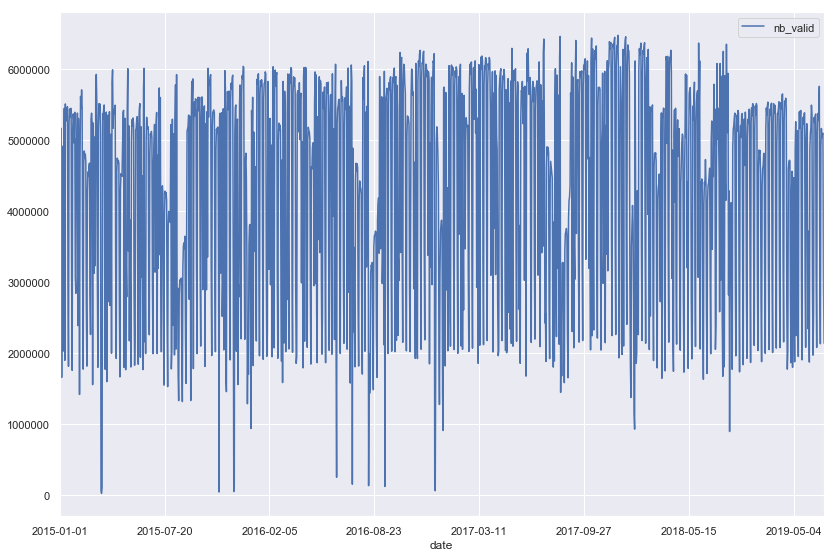

In [57]:
dt_agg.groupby('date').sum().plot()

In [58]:
dt_agg

,date,station,nb_valid
0,2015-01-01,ABBESSES,750
1,2015-01-01,ABLON,118
2,2015-01-01,ACHERES-GRAND-CORMIER,18
3,2015-01-01,ACHERES-VILLE,482
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257
...,...,...,...
1026013,2019-06-30,VOLTAIRE (LEON BLUM),6306
1026014,2019-06-30,VOSVES,10
1026015,2019-06-30,VULAINES-SUR-SEINE-SAMOREAU,20
1026016,2019-06-30,WAGRAM,1840


In [59]:
dt_agg.shape

(1026018, 3)

In [60]:
dt_agg.to_csv('./data/validation_data_agg_2015_2019.csv')

### 2 . Positions Data

In [61]:
pos = pd.read_csv("data/positions-geographiques-des-stations-du-reseau-ratp.csv", sep=';')
dt2 = pos[['Name','Coordinates']].copy()

l = np.array(dt2["Coordinates"].str.split(",").tolist())
dt2["lon"] = l[:,0]
dt2["lat"] = l[:,1]
dt2.drop("Coordinates",axis=1, inplace=True)

dt2['Name'] = dt2['Name'].str.lower()
dt2['Name'] = dt2['Name'].str.replace('[^\w]','')
dt2['Name'] = dt2['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

dt2['lon'] = pd.to_numeric(dt2["lon"])
dt2['lat'] = pd.to_numeric(dt2["lat"])
dt2.columns = ['station_name', 'lon', 'lat']

dt2 = dt2.groupby('station_name').mean().reset_index()
dt2.drop_duplicates(inplace=True)

dt2.head()

,station_name,lon,lat
0,11novembre,48.849993,2.395659
1,11novembre1918,48.824212,2.516243
2,11novembrecourcellesuryvetterer,48.700031,2.099321
3,12fevrier1934,48.817827,2.308055
4,17octobre1961,48.898062,2.216702


In [62]:
dt_agg['station_name'] = dt_agg['station'].str.lower()
dt_agg['station_name'] = dt_agg['station_name'].str.replace('[^\w]','')
dt_agg['station_name'] = dt_agg['station_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


In [63]:
dt_agg_pos = dt_agg.merge(dt2, how='left', on='station_name')
dt_agg_pos.drop('station_name',axis=1,inplace=True)
dt_agg_pos.head()

,date,station,nb_valid,lon,lat
0,2015-01-01,ABBESSES,750,48.884505,2.338365
1,2015-01-01,ABLON,118,NaN,NaN
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357


### 3 . Stations Data

In [64]:
gare_desc = pd.read_csv('data/emplacement-des-gares-idf-data-generalisee.csv',delimiter = ';')

In [65]:
gare_desc = pd.read_csv('data/emplacement-des-gares-idf-data-generalisee.csv',delimiter = ';')
stations_desc = pd.read_csv('data/stations.csv',delimiter = ';')
gare_desc = gare_desc[['nom_long','res_com','mode_','principal']]
gare_desc.columns = ['long_name','res_com','mode_','principal']

In [66]:
dt_agg_pos = pd.merge(dt_agg_pos,gare_desc,left_on='station',right_on='long_name',how = 'left') 
dt_agg_pos = dt_agg_pos.drop(columns = ['long_name'],axis = 1)

In [67]:
gare_desc.head()

,long_name,res_com,mode_,principal
0,REUILLY-DIDEROT,M1 / M8,Metro,0
1,LOUVRE-RIVOLI,M1,Metro,0
2,LES MILONS,T2,Tramway,0
3,LYCEE HENRI SELLIER,T4,Tramway,0
4,PARMENTIER,M3,Metro,0


In [68]:
gare_desc[gare_desc['long_name'].str.contains("NATION")]

,long_name,res_com,mode_,principal
419,NATIONALE,M6,Metro,0
522,NATION,RER A / M1 / M2 / M6 / M9,RER / Metro,0
573,ASSEMBLEE NATIONALE,M12,Metro,0


### 4 . Correspondences  Data

In [69]:
corr = pd.read_csv('data/correspondances.csv')
corr['Name'] = corr['stop_name'].str.lower()
corr['Name'] = corr['Name'].str.replace('[^\w]','')
corr['Name'] = corr['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

dt_agg_pos['Name'] = dt_agg_pos['station'].str.lower()
dt_agg_pos['Name'] = dt_agg_pos['Name'].str.replace('[^\w]','')
dt_agg_pos['Name'] = dt_agg_pos['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

dt_agg_pos_corr = dt_agg_pos.merge(corr, how='left', on='Name')
dt_agg_pos_corr.drop(['Name','stop_name'],axis=1,inplace=True)
dt_agg_pos_corr.head()

,date,station,nb_valid,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,12
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,NaN
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,NaN
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,NaN
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,NaN


In [70]:
dt_agg_pos_corr[dt_agg_pos_corr['station'].str.contains("HALLES")].head()

,date,station,nb_valid,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line
139,2015-01-01,CHATELET-LES HALLES,13278,48.861630,2.346824,RER A / RER B / RER D,RER,1.0,0.0,3.0,NaN
375,2015-01-01,LES HALLES,8319,48.862012,2.346476,M4,Metro,0.0,1.0,0.0,4
915,2015-01-02,CHATELET-LES HALLES,22781,48.861630,2.346824,RER A / RER B / RER D,RER,1.0,0.0,3.0,NaN
1152,2015-01-02,LES HALLES,14908,48.862012,2.346476,M4,Metro,0.0,1.0,0.0,4
1696,2015-01-03,CHATELET-LES HALLES,24157,48.861630,2.346824,RER A / RER B / RER D,RER,1.0,0.0,3.0,NaN


### 5 . Stations Repository Data

In [71]:
ref = pd.read_csv('data/referentiel-gares-voyageurs.csv',delimiter = ';')
ref  = ref[['Intitulé gare','Segment DRG','Nbre plateformes']]
ref['Intitulé gare'] = ref['Intitulé gare'].apply(lambda x : x.upper())
ref.columns = ['Intitulé gare','segment_DRG','nb_plateform']

In [72]:
dt_agg_pos_corr = pd.merge(dt_agg_pos_corr,ref,left_on='station',right_on='Intitulé gare',how = 'left') 
dt_agg_pos_corr = dt_agg_pos_corr.drop(columns = ['Intitulé gare'],axis=1)
dt_agg_pos_corr.head()

,date,station,nb_valid,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line,segment_DRG,nb_plateform
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,12,NaN,NaN
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,NaN,b,1.0
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,NaN,NaN,NaN
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,NaN,NaN,NaN
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,NaN,NaN,NaN


### 6 . Incidents Data

In [73]:
inc = pd.read_csv('./data/incidents_2016_2019_clean.csv')
inc['day'] = inc['date'].str[:10]
inc['duree'] = pd.to_timedelta(inc['duree'])
inc.head()

,duree,date,line_num,line_type,what,type_inc,day
0,00:00:00,2016-07-01 10:34:00,12,metro,pedestrian,unscheduled,2016-07-01
1,00:00:00,2016-07-01 10:42:00,12,metro,pedestrian,unscheduled,2016-07-01
2,00:00:00,2016-07-01 11:30:00,12,metro,pedestrian,unscheduled,2016-07-01
3,00:37:00,2016-07-01 12:57:00,6,metro,unattended_luggage,unscheduled,2016-07-01
4,00:10:00,2016-07-01 13:35:00,6,metro,unattended_luggage,unscheduled,2016-07-01


In [74]:
inc_group = inc.groupby(['day','line_num']).agg({
    'duree' : sum,
    'what' : 'first',
    'type_inc' : 'count'
}).reset_index().rename(columns={'type_inc':'num_inc','what':'type_inc'})
inc_group['day'] = pd.to_datetime(inc_group['day'])
inc_group.columns = ['date', 'line_nb', 'duration', 'type_inc', 'nb_inc']

inc_group.head()

,date,line_nb,duration,type_inc,nb_inc
0,2016-05-01,1,00:00:00,generic,2
1,2016-05-01,11,00:00:00,smoke,1
2,2016-05-01,13,00:26:00,breakdown,4
3,2016-05-01,2,00:00:00,breakdown,3
4,2016-05-01,7,00:00:00,breakdown,2


In [75]:
inc_station = inc_group.merge(corr, how='left',left_on='line_nb',right_on='line').drop(['line','Name','nb_metro','nb_rer'],axis=1)

inc_station.head()

,date,line_nb,duration,type_inc,nb_inc,stop_name
0,2016-05-01,1,0 days,generic,2,REUILLY-DIDEROT
1,2016-05-01,1,0 days,generic,2,LOUVRE-RIVOLI
2,2016-05-01,1,0 days,generic,2,CONCORDE
3,2016-05-01,1,0 days,generic,2,GEORGE V
4,2016-05-01,1,0 days,generic,2,ARGENTINE


In [76]:
dt_agg_pos_corr.head()

,date,station,nb_valid,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line,segment_DRG,nb_plateform
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,12,NaN,NaN
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,NaN,b,1.0
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,NaN,NaN,NaN
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,NaN,NaN,NaN
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,NaN,NaN,NaN


In [77]:
inc_station['Name'] = inc_station['stop_name'].str.lower()
inc_station['Name'] = inc_station['Name'].str.replace('[^\w]','')
inc_station['Name'] = inc_station['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

inc_station['date'] = inc_station['date'].astype(str)

curr_dt = dt_agg_pos_corr.copy()

curr_dt['Name'] = curr_dt['station'].str.lower()
curr_dt['Name'] = curr_dt['Name'].str.replace('[^\w]','')
curr_dt['Name'] = curr_dt['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

curr_dt['date'] = curr_dt['date'].astype(str)

In [78]:
dt_pos_cor_inc = curr_dt.merge(inc_station, how='left',left_on=['date','Name'], right_on=['date','Name'])
dt_pos_cor_inc.drop(['Name','line_nb','stop_name'],axis=1,inplace=True)

dt_pos_cor_inc.head()

,date,station,nb_valid,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line,segment_DRG,nb_plateform,duration,type_inc,nb_inc
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,12,NaN,NaN,NaT,NaN,NaN
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,NaN,b,1.0,NaT,NaN,NaN
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,NaN,NaN,NaN,NaT,NaN,NaN
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,NaN,NaN,NaN,NaT,NaN,NaN
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,NaN,NaN,NaN,NaT,NaN,NaN


In [79]:
dt_pos_cor_inc.loc[dt_pos_cor_inc['nb_inc'].notna()].head()

,date,station,nb_valid,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line,segment_DRG,nb_plateform,duration,type_inc,nb_inc
375032,2016-05-01,ALEXANDRE DUMAS,10584,48.872031,2.416374,M2,Metro,0.0,1.0,0.0,2,NaN,NaN,00:00:00,breakdown,3.0
375039,2016-05-01,ANVERS,9382,48.882872,2.344164,M2,Metro,0.0,1.0,0.0,2,NaN,NaN,00:00:00,breakdown,3.0
375042,2016-05-01,ARGENTINE,8038,48.875693,2.289097,M1,Metro,0.0,1.0,0.0,1,NaN,NaN,00:00:00,generic,2.0
375058,2016-05-01,AVRON,5099,48.850355,2.465669,M2,Metro,0.0,1.0,0.0,2,NaN,NaN,00:00:00,breakdown,3.0
375061,2016-05-01,BALARD,13411,48.836384,2.278305,M8 / T3A,Metro / Tramway,0.0,1.0,0.0,8,NaN,NaN,01:55:00,breakdown,5.0


### 7 . Social movements Data

In [80]:
mvs = pd.read_csv('data/mouvements-sociaux.csv',delimiter=';')
mvs['date_de_debut'] = pd.to_datetime(mvs['date_de_debut'],format="%Y/%m/%d")
mvs['date_de_fin'] = pd.to_datetime(mvs['date_de_fin'],format="%Y/%m/%d")
mvs  = mvs[mvs['date_de_debut'].isin(pd.date_range(start='20150101', end='20190630'))]
mvs_dates = mvs[['date_de_debut','date_de_fin']]

In [81]:
list_dates = []
for index in mvs_dates.index:
    start_date = mvs_dates['date_de_debut'][index]
    if  not pd.isna(mvs_dates['date_de_fin'][index]): 
        end_date = mvs_dates['date_de_fin'][index]
        for n in range(int ((end_date - start_date).days)):
            list_dates.append(start_date + timedelta(n))
    else : 
        list_dates.append(start_date)

In [82]:
mvs_dates = {'date': list_dates}
mvs_dates = pd.DataFrame(data=mvs_dates)
mvs_dates['is_strike'] = np.ones(mvs_dates.shape[0])

In [83]:
dt_pos_cor_inc['date'] = pd.to_datetime(dt_pos_cor_inc['date'])
df_merged = pd.merge(dt_pos_cor_inc,mvs_dates, left_on='date',right_on='date',how='left')
df_merged["is_strike"].fillna(0, inplace = True)
df_merged.head()

,date,station,nb_valid,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line,segment_DRG,nb_plateform,duration,type_inc,nb_inc,is_strike
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,12,NaN,NaN,NaT,NaN,NaN,0.0
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,NaN,b,1.0,NaT,NaN,NaN,0.0
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,NaN,NaN,NaN,NaT,NaN,NaN,0.0
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,NaN,NaN,NaN,NaT,NaN,NaN,0.0
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,NaN,NaN,NaN,NaT,NaN,NaN,0.0


###  8 . Stations timetable Data

In [84]:
horaires_gares = pd.read_csv('data/horaires-des-gares.csv',delimiter = ';')
horaires_gares = horaires_gares[['Gare','Jour de la semaine','Horaire en jour normal', 'Horaire en jour férié']]
horaires_gares['Gare']  = horaires_gares['Gare'].apply(lambda x : x.upper())
horaires_gares.head()

,Gare,Jour de la semaine,Horaire en jour normal,Horaire en jour férié
0,BANYULS-SUR-MER,Mercredi,14:30-18:00,NaN
1,BANYULS-SUR-MER,Jeudi,09:15-13:00,NaN
2,ARGELÈS-SUR-MER,Vendredi,05:35-22:10,05:35-22:10
3,RIVESALTES,Lundi,05:30-22:35,05:30-22:35
4,RIVESALTES,Mardi,05:30-22:35,05:30-22:35


In [85]:
df_merged['week_day'] = df_merged['date'].apply(lambda x : calendar.day_name [x.date().weekday()])
jour_eng = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
jour_fr = ['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche']
horaires_gares['Jour de la semaine'] = horaires_gares['Jour de la semaine'].apply(lambda x : jour_eng[jour_fr.index(x)])
horaires_gares.columns = ['station', 'week_day', 'business_day_schedule', 'day_off_schedule']
horaires_gares.head()

,station,week_day,business_day_schedule,day_off_schedule
0,BANYULS-SUR-MER,Wednesday,14:30-18:00,NaN
1,BANYULS-SUR-MER,Thursday,09:15-13:00,NaN
2,ARGELÈS-SUR-MER,Friday,05:35-22:10,05:35-22:10
3,RIVESALTES,Monday,05:30-22:35,05:30-22:35
4,RIVESALTES,Tuesday,05:30-22:35,05:30-22:35


In [86]:
df_merged = pd.merge(df_merged,horaires_gares , on = ['station','week_day'],how = 'left')
df_merged.head()

,date,station,nb_valid,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,line,segment_DRG,nb_plateform,duration,type_inc,nb_inc,is_strike,week_day,business_day_schedule,day_off_schedule
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,12,NaN,NaN,NaT,NaN,NaN,0.0,Thursday,NaN,NaN
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,NaN,b,1.0,NaT,NaN,NaN,0.0,Thursday,NaN,NaN
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,NaN,NaN,NaN,NaT,NaN,NaN,0.0,Thursday,NaN,NaN
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,NaN,NaN,NaN,NaT,NaN,NaN,0.0,Thursday,NaN,NaN
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,NaN,NaN,NaN,NaT,NaN,NaN,0.0,Thursday,NaN,NaN


### 9 . Day off Data

In [87]:
day_off_data = pd.read_csv("./data/jours-feries.csv")
day_off_data.columns = ['date','is_day_off','day_off_type']
day_off_data.head()

,date,is_day_off,day_off_type
0,1950-01-01,True,Jour de l'an
1,1950-01-02,False,NaN
2,1950-01-03,False,NaN
3,1950-01-04,False,NaN
4,1950-01-05,False,NaN


Let's deal with NaN values

In [88]:
# Let's convert dates into datetime type
day_off_data['date'] = pd.to_datetime(day_off_data['date'],format="%Y/%m/%d")
# Let's keep only dates between 2015-01-01 and 2019-06-30
day_off_data = day_off_data[day_off_data['date'].isin(pd.date_range(start='20150101', end='20190630'))]
# Let's replace NaN values by "jour non ferie"
day_off_data["day_off_type"].fillna("other", inplace = True)


In [89]:
# Encoder la colonne 'est_jour_ferié' : True => 1 et False => 0
day_off_data.is_day_off = day_off_data.is_day_off.astype(int)

### 10 .  Feature Engineering:  Week-End Days

In [90]:
day_off_data['is_weekend'] = day_off_data['date'].map(lambda x : 1 if x.weekday() >= 5 else 0 )
day_off_data.head()

,date,is_day_off,day_off_type,is_weekend
23741,2015-01-01,1,Jour de l'an,0
23742,2015-01-02,0,other,0
23743,2015-01-03,0,other,1
23744,2015-01-04,0,other,1
23745,2015-01-05,0,other,0


In [91]:
#Let's add the type "Weekend" in the column "type_jour"
mask = (day_off_data['is_weekend'] == 1) 
day_off_data['day_off_type'][mask] = "Weekend"
day_off_data.head()

,date,is_day_off,day_off_type,is_weekend
23741,2015-01-01,1,Jour de l'an,0
23742,2015-01-02,0,other,0
23743,2015-01-03,0,Weekend,1
23744,2015-01-04,0,Weekend,1
23745,2015-01-05,0,other,0


In [92]:
day_off_data.drop('is_weekend',axis=1,inplace=True)
day_off_data.head()

,date,is_day_off,day_off_type
23741,2015-01-01,1,Jour de l'an
23742,2015-01-02,0,other
23743,2015-01-03,0,Weekend
23744,2015-01-04,0,Weekend
23745,2015-01-05,0,other


In [93]:
df_merged = pd.merge(df_merged, day_off_data, left_on='date',right_on='date',how='left')
df_merged.head()

,date,station,nb_valid,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,...,nb_plateform,duration,type_inc,nb_inc,is_strike,week_day,business_day_schedule,day_off_schedule,is_day_off,day_off_type
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,...,NaN,NaT,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,...,1.0,NaT,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,...,NaN,NaT,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,...,NaN,NaT,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,...,NaN,NaT,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an


In [94]:
X_train,X_test = train_test_split(df_merged, test_size=0.33, random_state=42)

In [95]:
X_train.head()

,date,station,nb_valid,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,...,nb_plateform,duration,type_inc,nb_inc,is_strike,week_day,business_day_schedule,day_off_schedule,is_day_off,day_off_type
259473,2015-12-01,LES GRESILLONS,3008,NaN,NaN,RER C,RER,0.0,0.0,1.0,...,NaN,NaT,NaN,NaN,0.0,Tuesday,NaN,NaN,0,other
255030,2015-11-25,ERMONT-HALTE,544,NaN,NaN,LIGNE H,Train,0.0,0.0,0.0,...,NaN,NaT,NaN,NaN,0.0,Wednesday,NaN,NaN,0,other
490696,2016-09-19,COURCELLE-SUR-YVETTE,1091,48.700934,2.099045,RER B,RER,0.0,0.0,1.0,...,NaN,NaT,NaN,NaN,0.0,Monday,NaN,NaN,0,other
1047961,2019-02-23,RAMBOUILLET,2718,48.844479,2.381176,LIGNE N,Train,1.0,0.0,0.0,...,1.0,NaT,NaN,NaN,0.0,Saturday,NaN,NaN,0,Weekend
1050591,2019-02-27,FR. POPULAIRE,7627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaT,NaN,NaN,0.0,Wednesday,NaN,NaN,0,other


More feature engineering in "starting_kit.ipynb"

In [96]:
X_train.to_csv('./data/data challenge/data_challenge_TRAIN.csv',index=False)
X_test.to_csv('./data/data challenge/data_challenge_TEST.csv',index=False)